# Credit Default Prediction — Machine Learning Project  
**ESILV 2025 — Supervised Learning, Imbalanced Data, and Advanced Models**

### Team:
- Gabriel PICARD  
- Thibault PELOU  
- Hugo PICARD  

---

## Project Objective
Predict whether a client will **default** using:
- Client application data (`application_record.csv`)
- Credit repayment history (`credit_record.csv`)

The target variable is built as:
- **target = 1** if the client had at least one delinquency (`STATUS ∈ {1,2,3,4,5}`)  
- **target = 0** otherwise  

---

## Notebook Structure
1. **Import libraries & load data**  
2. **Target creation (your exact logic)**  
3. **Exploratory Data Analysis (EDA)**  
4. **Preprocessing**  
5. **Baseline model**  
6. **Standard ML models (Decision Tree, Random Forest, SVM, PCA)**  
7. **Imbalanced data methods (Oversampling, SMOTE, class-weight)**  
8. **Advanced model: XGBoost**  
9. **Threshold optimization**  
10. **Global results comparison**


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
    auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

import warnings
warnings.filterwarnings("ignore")

### Load dataset

In [3]:
app = pd.read_csv("application_record.csv")
credit = pd.read_csv("credit_record.csv")

print("Application shape:", app.shape)
print("Credit shape:", credit.shape)

# Remove duplicates on application data
app = app.drop_duplicates(subset="ID")


Application shape: (438557, 18)
Credit shape: (1048575, 3)


### Create target variable

In [4]:
credit["value"] = None
credit.loc[credit["STATUS"].isin(["1","2","3","4","5"]), "value"] = "Yes"
countV = credit.groupby("ID").count()
countV["value"] = countV["value"].astype(object)
countV.loc[countV["value"] > 0, "value"] = "Yes"
countV.loc[countV["value"] == 0, "value"] = "No"
countV = countV[["value"]]
data = pd.merge(app, countV, on="ID", how="inner")
data["target"] = (data["value"] == "Yes").astype(int)
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,Yes,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,Yes,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,No,0


## 🔍 Exploratory Data Analysis (EDA)

We explore:
- Missing values  
- Distribution of the target  
- Summary statistics  
- Correlation matrix  
- Types of features  


### Dataset infos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

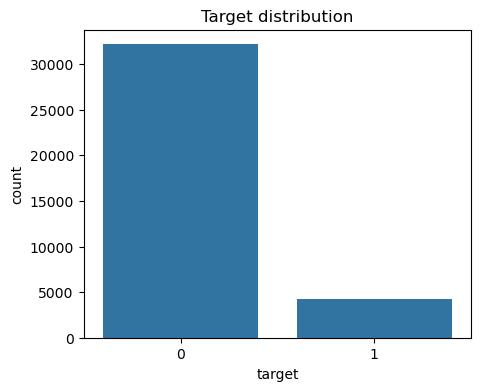

target
0    0.8823
1    0.1177
Name: proportion, dtype: float64

In [5]:
print(data.info())
print("\nMissing values:\n", data.isnull().sum())
plt.figure(figsize=(5,4))
sns.countplot(x=data["target"])
plt.title("Target distribution")
plt.show()
data["target"].value_counts(normalize=True)

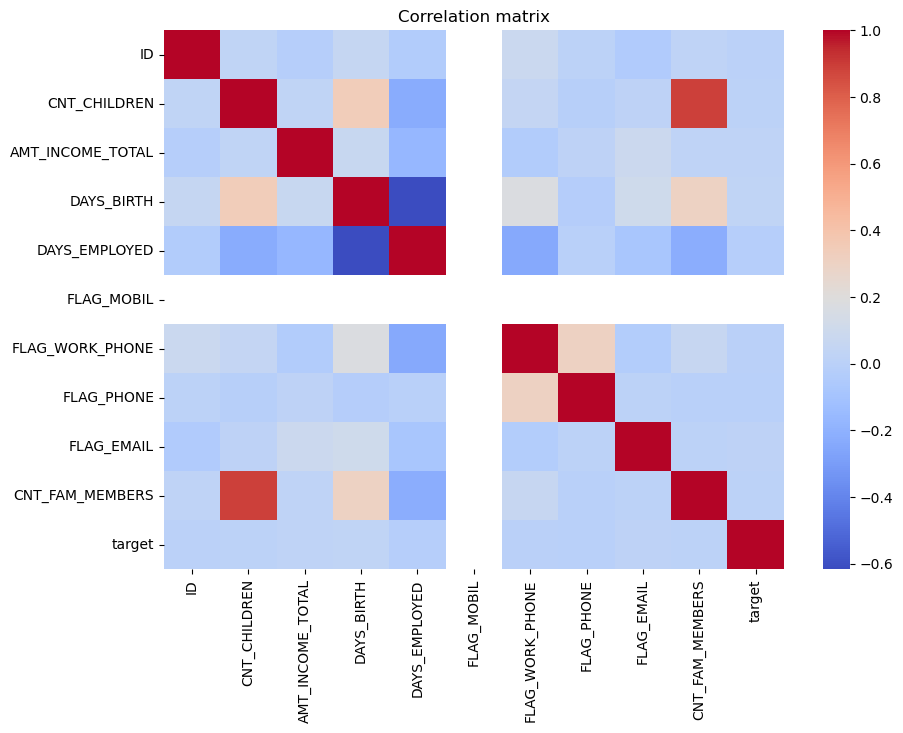

In [6]:
numeric_df = data.select_dtypes(include=["int64","float64"])
plt.figure(figsize=(10,7))
sns.heatmap(numeric_df.corr(), cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

### Preprocessing

In [7]:
X = data.drop(columns=["target", "value", "ID"])
y = data["target"]
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64","float64"]).columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### Baseline Model: Logistic Regression

In [8]:
baseline_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=800))
])
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)
print(classification_report(y_test, baseline_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      9651
           1       1.00      0.00      0.00      1287

    accuracy                           0.88     10938
   macro avg       0.94      0.50      0.47     10938
weighted avg       0.90      0.88      0.83     10938



In [9]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):  
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    if hasattr(model, "predict_proba"):
        roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    else:
        roc = roc_auc_score(y_test, model.decision_function(X_test)) 
    print(f"\n===== {name} =====")
    print(classification_report(y_test, pred))
    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": roc
    }

### Standard Machine Learning Models

In [10]:
results = []

# Decision Tree
tree_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=None, random_state=42))
])
results.append(evaluate_model("Decision Tree", tree_model, X_train, X_test, y_train, y_test))

# Random Forest
rf_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])
results.append(evaluate_model("Random Forest", rf_model, X_train, X_test, y_train, y_test))

# SVM
svm_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", SVC(kernel="rbf", probability=True, random_state=42))
])
results.append(evaluate_model("SVM (RBF Kernel)", svm_model, X_train, X_test, y_train, y_test))


===== Decision Tree =====
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      9651
           1       0.47      0.29      0.36      1287

    accuracy                           0.88     10938
   macro avg       0.69      0.63      0.65     10938
weighted avg       0.86      0.88      0.87     10938


===== Random Forest =====
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      9651
           1       0.54      0.28      0.37      1287

    accuracy                           0.89     10938
   macro avg       0.72      0.63      0.65     10938
weighted avg       0.87      0.89      0.87     10938


===== SVM (RBF Kernel) =====
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      9651
           1       0.62      0.00      0.01      1287

    accuracy                           0.88     10938
   macro avg       0.75      0.50      0.47 

### PCA

In [11]:
pca_model = Pipeline([
    ("preprocess", preprocessor),
    ("pca", PCA(n_components=10)),
    ("model", LogisticRegression(max_iter=800))
])
results.append(evaluate_model("LogReg + PCA", pca_model, X_train, X_test, y_train, y_test))


===== LogReg + PCA =====
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      9651
           1       0.00      0.00      0.00      1287

    accuracy                           0.88     10938
   macro avg       0.44      0.50      0.47     10938
weighted avg       0.78      0.88      0.83     10938



### Cost-Sensitive Models

In [12]:
logreg_bal = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=800, class_weight="balanced"))
])
results.append(evaluate_model("LogReg (balanced)", logreg_bal, X_train, X_test, y_train, y_test))
rf_bal = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42))
])
results.append(evaluate_model("RandomForest (balanced)", rf_bal, X_train, X_test, y_train, y_test))


===== LogReg (balanced) =====
              precision    recall  f1-score   support

           0       0.90      0.60      0.72      9651
           1       0.14      0.48      0.21      1287

    accuracy                           0.58     10938
   macro avg       0.52      0.54      0.46     10938
weighted avg       0.81      0.58      0.66     10938


===== RandomForest (balanced) =====
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      9651
           1       0.37      0.51      0.43      1287

    accuracy                           0.84     10938
   macro avg       0.65      0.70      0.67     10938
weighted avg       0.86      0.84      0.85     10938



### Resampling

In [13]:
# Random Oversampling
ros_rf = ImbPipeline([
    ("preprocess", preprocessor),
    ("ros", RandomOverSampler(random_state=42)),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])
results.append(evaluate_model("RandomForest + Oversampling", ros_rf, X_train, X_test, y_train, y_test))

# SMOTE
smote_rf = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])
results.append(evaluate_model("RandomForest + SMOTE", smote_rf, X_train, X_test, y_train, y_test))


===== RandomForest + Oversampling =====
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      9651
           1       0.33      0.59      0.42      1287

    accuracy                           0.81     10938
   macro avg       0.63      0.71      0.65     10938
weighted avg       0.87      0.81      0.83     10938


===== RandomForest + SMOTE =====
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      9651
           1       0.41      0.40      0.40      1287

    accuracy                           0.86     10938
   macro avg       0.67      0.66      0.66     10938
weighted avg       0.86      0.86      0.86     10938



### XGBoost

In [14]:
try:
    from xgboost import XGBClassifier

    xgb_model = ImbPipeline([
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            random_state=42
        ))
    ])
    results.append(evaluate_model("XGBoost + SMOTE", xgb_model, X_train, X_test, y_train, y_test))

except ImportError:
    print("XGBoost not installed; skipping.")



===== XGBoost + SMOTE =====
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      9651
           1       0.25      0.10      0.15      1287

    accuracy                           0.86     10938
   macro avg       0.57      0.53      0.53     10938
weighted avg       0.81      0.86      0.83     10938



### Threshold Optimisation

In [15]:
best_model = smote_rf
best_model_name = "RandomForest + SMOTE"
best_model.fit(X_train, y_train)
y_scores = best_model.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, y_scores)
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_vals)
best_thr = thr[best_idx]
print("Best threshold:", best_thr)
print("Best F1:", f1_vals[best_idx])
y_pred_opt = (y_scores >= best_thr).astype(int)
print("\nReport with optimized threshold:")
print(classification_report(y_test, y_pred_opt))

Best threshold: 0.3101035353535353
Best F1: 0.41962357249248217

Report with optimized threshold:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      9651
           1       0.35      0.53      0.42      1287

    accuracy                           0.83     10938
   macro avg       0.64      0.70      0.66     10938
weighted avg       0.86      0.83      0.84     10938



### Final Model Comparison

In [16]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1", ascending=False)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
5,RandomForest (balanced),0.838636,0.366331,0.508936,0.426016,0.786832
6,RandomForest + Oversampling,0.809197,0.326690,0.585859,0.419471,0.789388
7,RandomForest + SMOTE,0.862223,0.411576,0.397824,0.404583,0.786901
1,Random Forest,0.886817,0.535871,0.284382,0.371574,0.790080
0,Decision Tree,0.878406,0.473091,0.293706,0.362416,0.740546
4,LogReg (balanced),0.582465,0.136202,0.477078,0.211907,0.553721
8,XGBoost + SMOTE,0.857287,0.248162,0.104895,0.147460,0.586094
2,SVM (RBF Kernel),0.882520,0.625000,0.003885,0.007722,0.668086
3,LogReg + PCA,0.882337,0.000000,0.000000,0.000000,0.538121
